In [ ]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import random

# NetworkX
import networkx as nx
from networkx.algorithms.components import connected_components
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.distance_measures import eccentricity, diameter
from networkx.algorithms import bipartite
from networkx.algorithms.community import greedy_modularity_communities

#Misspelling algorithm
import csv
from collections import defaultdict
import Levenshtein
import os

# Bipartite graph
from collections import Counter
from scipy import stats

# Neo4j
import neo4j

# 1. Network Source

**Primary source**: Marvel characters and comics [dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

**Data components**:
- `nodes.csv`: Contains node identifiers and types (hero or comic)
- `edges.csv`: Contains hero-comic relationships (which heroes appear in which comics)

# 2. Data Persistence

**Saves the data in a Neo4J Database**: Marvel characters and comics [dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)


In [ ]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
# credentials ..
username = "neo4j"
password = "password"

driver = GraphDatabase.driver(uri, auth=("neo4j", ""))

# Load the datasets
nodes_df = pd.read_csv('Data/nodes_corr.csv')
edges_df = pd.read_csv('Data/edges_corr.csv')
hero_network_df = pd.read_csv('Data/hero-network.csv')

def insert_data(tx, data):
    hero = row['hero']
    comic = row['comic']
    cypher_query = '''MERGE (h:Hero {name: $hero})
        MERGE (c:Comic {name: $comic})
        MERGE (h)-[:APPEARED_IN]->(c)'''
    tx.run(cypher_query, hero=hero, comic=comic)


# Iterate through hero dataset ..
with driver.session() as session:
    for index, row in edges_df.iterrows():
        session.write_transaction(insert_data, row)

/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_10207/3852714176.py:27: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_data, row)


AuthError: {code: Neo.ClientError.Security.Unauthorized} {message: The client is unauthorized due to authentication failure.}

# 2. Data Loading

In [4]:

def fetch_data(tx):
    get_query = '''MATCH (h:Hero)-[:APPEARED_IN]->(c:Comic)
    RETURN h.name AS hero, c.name AS comic'''
    result = tx.run(get_query)
    return [record.data() for record in result]

with driver.session() as session:
    edges_df = session.read_transaction(fetch_data)

# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())


/var/folders/g2/wh8_2ch956s2v2xy8cz_xgqm0000gn/T/ipykernel_10035/4152888387.py:8: DeprecationWarning: read_transaction has been renamed to execute_read
  edges_df = session.read_transaction(fetch_data)
Transaction failed and will be retried in 0.8261103678859052s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [Errno 61] Connection refused)
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 61] Connection refused))
Transaction failed and will be retried in 1.9546367315947406s (Couldn't connect to localhost:7687 (resolved to ('[::1]:7687', '127.0.0.1:7687')):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [Errno 61] Connection refused)
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 61] Connection refused))
Transaction failed and will be retried in 4.4532

KeyboardInterrupt: 

In [6]:
#load data manually if neo4j is not available
nodes_df = pd.read_csv('Data/nodes.csv')
edges_df = pd.read_csv('Data/edges.csv')

# 3. Data Quality and Preprocessing

## 3.1. Quality check 

### 3.1.1 Misspelling mistakes

This script analyzes hero names across two DataFrames (edges_df and nodes_df) to identify potential spelling inconsistencies in hero and comic names.

In [7]:
# Configuration
SIMILARITY_THRESHOLD = 0.8  # Minimum similarity to consider (0-1)
MIN_NAME_LENGTH = 4  # Minimum name length to compare
OUTPUT_PREFIX = 'entity_spelling_results'  # Output file prefix
RESULT_LIMIT = None  # Limit number of results (None for all)

In [8]:
# Function to load entity names from DataFrames
def load_entity_names_from_dataframes(edges_df, nodes_df):
    """
    Load hero and comic names from existing DataFrames and track their sources.
    
    Returns:
        dict: A dictionary with entity names as keys and a dict of info as values
    """
    entity_sources = defaultdict(lambda: {'type': None, 'edges': False, 'nodes': False})
    
    # Load heroes from edges_df
    try:
        for hero in edges_df['hero'].unique():
            entity_sources[hero]['type'] = 'hero'
            entity_sources[hero]['edges'] = True
        print(f"Loaded {len(edges_df['hero'].unique())} unique heroes from edges_df")
    except Exception as e:
        print(f"Error processing heroes in edges_df: {e}")
    
    # Load comics from edges_df
    try:
        for comic in edges_df['comic'].unique():
            entity_sources[comic]['type'] = 'comic'
            entity_sources[comic]['edges'] = True
        print(f"Loaded {len(edges_df['comic'].unique())} unique comics from edges_df")
    except Exception as e:
        print(f"Error processing comics in edges_df: {e}")
    
    # Load from nodes_df
    try:
        # Load heroes from nodes_df
        hero_nodes = nodes_df[nodes_df['type'] == 'hero']
        for hero in hero_nodes['node'].unique():
            entity_sources[hero]['type'] = 'hero'
            entity_sources[hero]['nodes'] = True
        print(f"Loaded {len(hero_nodes['node'].unique())} unique heroes from nodes_df")
        
        # Load comics from nodes_df
        comic_nodes = nodes_df[nodes_df['type'] == 'comic']
        for comic in comic_nodes['node'].unique():
            entity_sources[comic]['type'] = 'comic'
            entity_sources[comic]['nodes'] = True
        print(f"Loaded {len(comic_nodes['node'].unique())} unique comics from nodes_df")
    except Exception as e:
        print(f"Error processing nodes_df: {e}")
    
    heroes_count = sum(1 for info in entity_sources.values() if info['type'] == 'hero')
    comics_count = sum(1 for info in entity_sources.values() if info['type'] == 'comic')
    print(f"Total unique entities: {len(entity_sources)} ({heroes_count} heroes, {comics_count} comics)")
    
    return entity_sources


def calculate_similarity(str1, str2):
    """
    Calculate string similarity based on Levenshtein distance.
    
    Returns:
        float: Similarity score between 0 and 1
    """
    distance = Levenshtein.distance(str1.lower(), str2.lower())
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len) if max_len > 0 else 1


def find_similar_names(entity_sources, threshold=0.8, min_length=4):
    """
    Find entity names that are similar but not identical.
    
    Args:
        entity_sources: Dictionary of entity names and their sources
        threshold: Minimum similarity score to consider (default: 0.8)
        min_length: Minimum length of names to compare (default: 4)
        
    Returns:
        dict: Dictionary with 'heroes' and 'comics' keys containing lists of similar pairs
    """
    similar_pairs = {'heroes': [], 'comics': []}
    processed_pairs = set()
    
    # Separate heroes and comics
    heroes = [name for name, info in entity_sources.items() if info['type'] == 'hero']
    comics = [name for name, info in entity_sources.items() if info['type'] == 'comic']
    
    # Sort by length for optimization
    heroes.sort(key=len)
    comics.sort(key=len)
    
    # Process heroes
    print(f"Finding similar hero names (threshold: {threshold}, min length: {min_length})...")
    total_heroes = len(heroes)
    
    for i, hero1 in enumerate(heroes):
        if len(hero1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total_heroes} heroes processed...")
            
        for hero2 in heroes[i+1:]:
            # Skip if second hero is much longer (optimization)
            if len(hero2) > len(hero1) * 1.5:
                break
                
            # Skip very short names
            if len(hero2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([hero1, hero2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(hero1, hero2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs['heroes'].append({
                    'entity1': hero1,
                    'entity2': hero2,
                    'similarity': similarity,
                    'sources1': entity_sources[hero1],
                    'sources2': entity_sources[hero2]
                })
    
    # Reset processed pairs for comics
    processed_pairs = set()
    
    # Process comics
    print(f"Finding similar comic names (threshold: {threshold}, min length: {min_length})...")
    total_comics = len(comics)
    
    for i, comic1 in enumerate(comics):
        if len(comic1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total_comics} comics processed...")
            
        for comic2 in comics[i+1:]:
            # Skip if second comic is much longer (optimization)
            if len(comic2) > len(comic1) * 1.5:
                break
                
            # Skip very short names
            if len(comic2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([comic1, comic2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(comic1, comic2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs['comics'].append({
                    'entity1': comic1,
                    'entity2': comic2,
                    'similarity': similarity,
                    'sources1': entity_sources[comic1],
                    'sources2': entity_sources[comic2]
                })
    
    # Sort by similarity (highest first)
    similar_pairs['heroes'].sort(key=lambda x: x['similarity'], reverse=True)
    similar_pairs['comics'].sort(key=lambda x: x['similarity'], reverse=True)
    
    return similar_pairs


def format_source_info(sources):
    """Format source information for display"""
    source_list = []
    if sources['edges']:
        source_list.append('edges_df')
    if sources['nodes']:
        source_list.append('nodes_df')
    return ', '.join(source_list)


def export_results(similar_pairs, output_prefix):
    """Export results to CSV files"""
    # Export hero results
    hero_output = f"{output_prefix}_heroes.csv"
    with open(hero_output, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Hero Name 1', 'Hero Name 2', 'Similarity (%)', 'Sources for Hero 1', 'Sources for Hero 2'])
        
        for pair in similar_pairs['heroes']:
            writer.writerow([
                pair['entity1'], 
                pair['entity2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Hero results exported to {hero_output}")
    
    # Export comic results
    comic_output = f"{output_prefix}_comics.csv"
    with open(comic_output, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Comic Name 1', 'Comic Name 2', 'Similarity (%)', 'Sources for Comic 1', 'Sources for Comic 2'])
        
        for pair in similar_pairs['comics']:
            writer.writerow([
                pair['entity1'], 
                pair['entity2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Comic results exported to {comic_output}")


# Main function to run the analysis with existing DataFrames
def run_analysis_with_dfs(edges_df, nodes_df):
    """Run the analysis using existing DataFrames"""
    print("Loading entity names from DataFrames...")
    entity_sources = load_entity_names_from_dataframes(edges_df, nodes_df)
    
    similar_pairs = find_similar_names(
        entity_sources, 
        threshold=SIMILARITY_THRESHOLD,
        min_length=MIN_NAME_LENGTH
    )
    
    # Apply result limit if specified
    if RESULT_LIMIT:
        similar_pairs['heroes'] = similar_pairs['heroes'][:RESULT_LIMIT]
        similar_pairs['comics'] = similar_pairs['comics'][:RESULT_LIMIT]
    
    print(f"Found {len(similar_pairs['heroes'])} potential hero name inconsistencies")
    print(f"Found {len(similar_pairs['comics'])} potential comic name inconsistencies")
    
    # Print top hero results
    print("\nTop potential hero inconsistencies:")
    for i, pair in enumerate(similar_pairs['heroes'][:5]):
        print(f"{i+1}. {pair['entity1']} <-> {pair['entity2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['entity1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['entity2']}: {format_source_info(pair['sources2'])}")
        print()
    
    # Print top comic results
    print("\nTop potential comic inconsistencies:")
    for i, pair in enumerate(similar_pairs['comics'][:5]):
        print(f"{i+1}. {pair['entity1']} <-> {pair['entity2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['entity1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['entity2']}: {format_source_info(pair['sources2'])}")
        print()
    
    # Export results to separate files
    export_results(similar_pairs, OUTPUT_PREFIX)
    
    # Create DataFrames for the results
    hero_results_df = pd.DataFrame([
        {
            'Entity 1': pair['entity1'],
            'Entity 2': pair['entity2'],
            'Similarity': pair['similarity'],
            'Sources 1': format_source_info(pair['sources1']),
            'Sources 2': format_source_info(pair['sources2'])
        }
        for pair in similar_pairs['heroes']
    ])
    
    comic_results_df = pd.DataFrame([
        {
            'Entity 1': pair['entity1'],
            'Entity 2': pair['entity2'],
            'Similarity': pair['similarity'],
            'Sources 1': format_source_info(pair['sources1']),
            'Sources 2': format_source_info(pair['sources2'])
        }
        for pair in similar_pairs['comics']
    ])
    
    return {
        'similar_pairs': similar_pairs,
        'hero_results_df': hero_results_df,
        'comic_results_df': comic_results_df
    }



In [9]:
results = run_analysis_with_dfs(edges_df, nodes_df)

results['similar_pairs']  # All similar pairs
results['hero_results_df']  # DataFrame with hero results
results['comic_results_df']  # DataFrame with comic results

Loading entity names from DataFrames...
Loaded 6439 unique heroes from edges_df
Loaded 12651 unique comics from edges_df
Loaded 6439 unique heroes from nodes_df
Loaded 12651 unique comics from nodes_df
Total unique entities: 19091 (6440 heroes, 12651 comics)
Finding similar hero names (threshold: 0.8, min length: 4)...
Progress: 100/6440 heroes processed...
Progress: 200/6440 heroes processed...
Progress: 300/6440 heroes processed...
Progress: 400/6440 heroes processed...
Progress: 500/6440 heroes processed...
Progress: 600/6440 heroes processed...
Progress: 700/6440 heroes processed...
Progress: 800/6440 heroes processed...
Progress: 900/6440 heroes processed...
Progress: 1000/6440 heroes processed...
Progress: 1100/6440 heroes processed...
Progress: 1200/6440 heroes processed...
Progress: 1300/6440 heroes processed...
Progress: 1400/6440 heroes processed...
Progress: 1500/6440 heroes processed...
Progress: 1600/6440 heroes processed...
Progress: 1700/6440 heroes processed...
Progress

,Entity 1,Entity 2,Similarity,Sources 1,Sources 2
0,ALL WINNERS COMICS 1,ALL WINNERS COMICS 2,0.95,"edges_df, nodes_df","edges_df, nodes_df"
1,ALL WINNERS COMICS 1,ALL WINNERS COMICS 3,0.95,"edges_df, nodes_df","edges_df, nodes_df"
2,ALL WINNERS COMICS 1,ALL WINNERS COMICS 4,0.95,"edges_df, nodes_df","edges_df, nodes_df"
3,ALL WINNERS COMICS 1,ALL WINNERS COMICS 5,0.95,"edges_df, nodes_df","edges_df, nodes_df"
4,ALL WINNERS COMICS 1,ALL WINNERS COMICS 7,0.95,"edges_df, nodes_df","edges_df, nodes_df"
...,...,...,...,...,...
95219,M/FAN 46/2,M/FAN 48/3,0.80,"edges_df, nodes_df","edges_df, nodes_df"
95220,M/FAN 46/2,M/FAN 54/2,0.80,"edges_df, nodes_df","edges_df, nodes_df"
95221,M/FAN 46/2,M/FAN 55/2,0.80,"edges_df, nodes_df","edges_df, nodes_df"
95222,PPTSS 12/2,PPTSS 49/2,0.80,"edges_df, nodes_df","edges_df, nodes_df"


After a torough inspection of the pairs with 90% of similarity or more from the outputed `entity_spelling_results_comics.csv` and `entity_spelling_results_heroes.csv`, we can see that there were no spelling mistakes in the comics' and heroes' names. This is likely due to the fact that we downloaded a dataset that is commonly used for graph analysis, and has therefore already been preprocessed.

We have corrected manually the spelling mistakes in our datasets and renamed the corrected files as: 
- `edges_corr.csv`
- `nodes_corr.csv`

Regarding the comics, there was no spelling mistake. Regarding the 

We will from now on use the corrected data.

## 3.2 Re-load the corrected data

In [26]:
# Load the datasets
nodes_df = pd.read_csv('Data/nodes.csv')
edges_df = pd.read_csv('Data/edges.csv')

# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())

Nodes DataFrame:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Edges DataFrame:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


# 4. Bipartite Graph: Heroes x Comics  
We will create the bipartite graph consisting of heroes and comics nodes, where there is an edge between a hero and a comic if the hero appears in the comic.

In [28]:
# Create the graph (B for bipartite)
B = nx.Graph()

# Add nodes with bipartite attribute
for _, row in nodes_df.iterrows():
    B.add_node(row['node'], bipartite=0 if row['type'] == 'comic' else 1)

# Add edges from edges_df (assuming hero-comic links)
for _, row in edges_df.iterrows():
    B.add_edge(row['hero'], row['comic'])


In [29]:

print(nx.algorithms.bipartite.is_bipartite(B))  # Should return True


True


In [27]:
# Check for nodes added by edges only
all_nodes_in_nodes_df = set(nodes_df['node'])
all_nodes_in_edges_df = set(edges_df['hero']).union(set(edges_df['comic']))
missing_nodes = all_nodes_in_edges_df - all_nodes_in_nodes_df

print("Missing nodes from nodes_df:", missing_nodes)


Missing nodes from nodes_df: set()


## 4.1 Network Exploration

In [30]:
# Split nodes based on the bipartite attribute
comics = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
heroes = set(B) - comics

# Create summary table
summary = pd.DataFrame({
    'Metric': [
        'Number of comics',
        'Number of heroes',
        'Total number of nodes',
        'Number of edges',
        'Average degree (overall)',
        'Average degree (heroes)',
        'Average degree (comics)',
        'Graph density',
        'Is connected?',
        'Number of connected components',
    ],
    'Value': [
        len(comics),
        len(heroes),
        B.number_of_nodes(),
        B.number_of_edges(),
        sum(dict(B.degree()).values()) / B.number_of_nodes(),
        sum(dict(B.degree(heroes)).values()) / len(heroes),
        sum(dict(B.degree(comics)).values()) / len(comics),
        nx.density(B),
        nx.is_connected(B),
        nx.number_connected_components(B),
    ]
})

summary


,Metric,Value
0,Number of comics,12651
1,Number of heroes,6439
2,Total number of nodes,19090
3,Number of edges,96104
4,Average degree (overall),10.068518
5,Average degree (heroes),14.925299
6,Average degree (comics),7.596554
7,Graph density,0.000527
8,Is connected?,False
9,Number of connected components,22


### 4.1.1 Isolated heroes and comics

In [31]:
# Get all isolated nodes (nodes with degree 0)
isolated_nodes = list(nx.isolates(B))

# Separate by type
isolated_comics = [n for n in isolated_nodes if B.nodes[n].get('bipartite') == 0]
isolated_heroes = [n for n in isolated_nodes if B.nodes[n].get('bipartite') == 1]

# Show counts and optionally the actual names
print(f"Number of isolated comics: {len(isolated_comics)}")
print(f"Number of isolated heroes: {len(isolated_heroes)}")

# See their names
print("Isolated comics:", isolated_comics)
print("Isolated heroes:", isolated_heroes)


Number of isolated comics: 0
Number of isolated heroes: 0
Isolated comics: []
Isolated heroes: []


### 4.1.2 Degree distribution

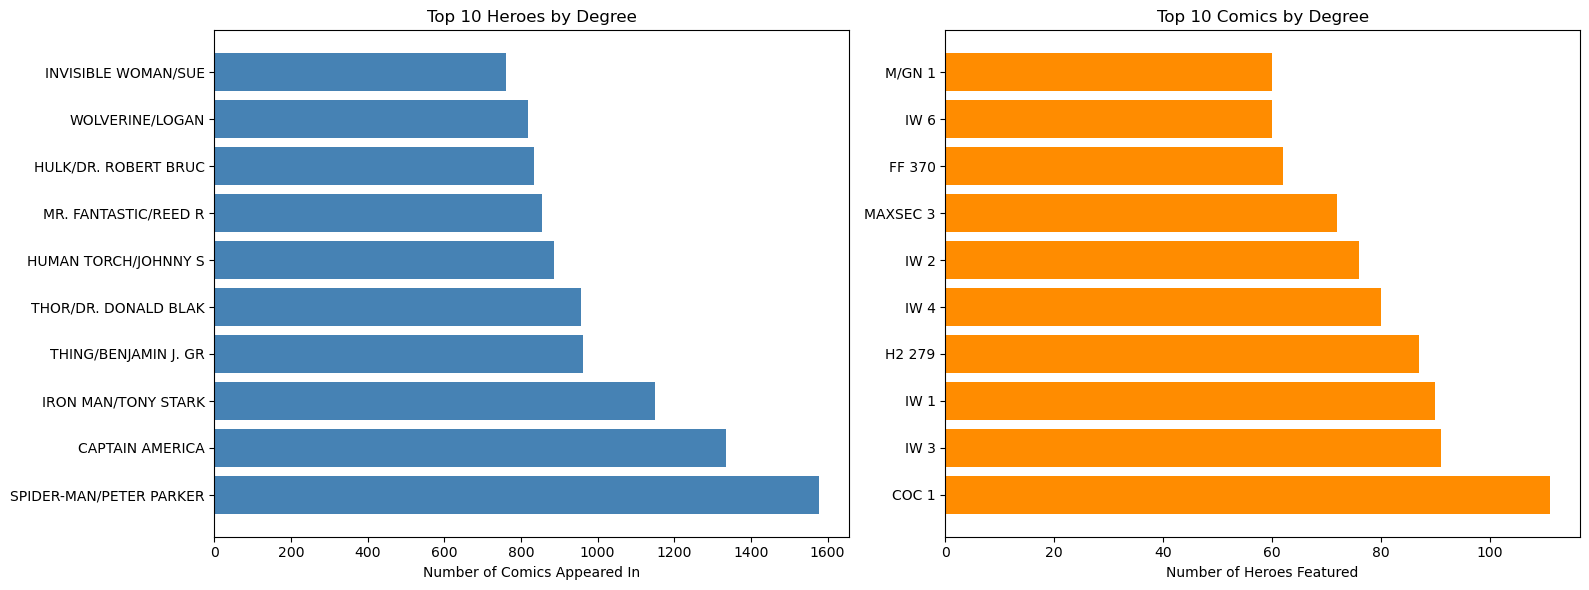

In [32]:
# Get degrees for all nodes
degrees = dict(B.degree())

# Separate degrees by type
comic_degrees = {n: deg for n, deg in degrees.items() if B.nodes[n].get('bipartite') == 0}
hero_degrees = {n: deg for n, deg in degrees.items() if B.nodes[n].get('bipartite') == 1}

# Get top 10 by degree
top_10_comics = sorted(comic_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_heroes = sorted(hero_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heroes
axes[0].barh(
    [name for name, _ in reversed(top_10_heroes)],
    [deg for _, deg in reversed(top_10_heroes)],
    color='steelblue'
)
axes[0].set_title('Top 10 Heroes by Degree')
axes[0].set_xlabel('Number of Comics Appeared In')
axes[0].invert_yaxis()

# Comics
axes[1].barh(
    [name for name, _ in reversed(top_10_comics)],
    [deg for _, deg in reversed(top_10_comics)],
    color='darkorange'
)
axes[1].set_title('Top 10 Comics by Degree')
axes[1].set_xlabel('Number of Heroes Featured')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


### 4.1.3 Path and Reachability

Subgraph Summary:
Number of nodes in Subgraph: 100
 - Comics: 0
 - Heroes: 100
Number of edges in Subgraph: 0


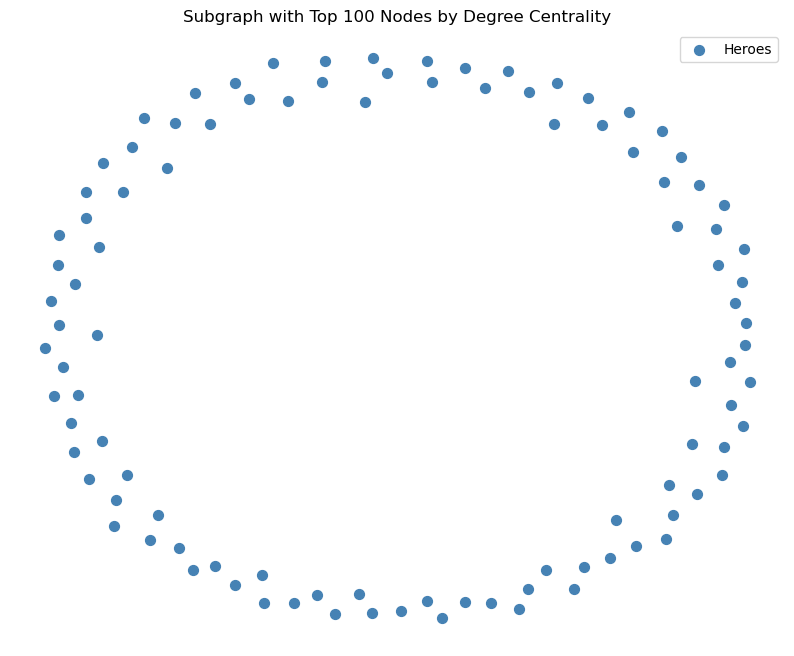

ZeroDivisionError: division by zero

In [37]:
# Compute degree centrality for the entire graph
degree_centrality = nx.degree_centrality(B)

# Select the top N nodes based on degree centrality
N = 100  # Select the top 100 nodes
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:N]

# Create subgraph with top nodes
B_subgraph = B.subgraph(top_nodes)

# Count node types
heroes_subgraph = {n for n in B_subgraph if B_subgraph.nodes[n].get('bipartite') == 1}
comics_subgraph = {n for n in B_subgraph if B_subgraph.nodes[n].get('bipartite') == 0}

# Quick stats on the subgraph
print("Subgraph Summary:")
print(f"Number of nodes in Subgraph: {B_subgraph.number_of_nodes()}")
print(f" - Comics: {len(comics_subgraph)}")
print(f" - Heroes: {len(heroes_subgraph)}")
print(f"Number of edges in Subgraph: {B_subgraph.number_of_edges()}")

# Visualize subgraph
pos = nx.spring_layout(B_subgraph, seed=42)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(B_subgraph, pos, nodelist=comics_subgraph, node_color='orange', label='Comics', node_size=50)
nx.draw_networkx_nodes(B_subgraph, pos, nodelist=heroes_subgraph, node_color='steelblue', label='Heroes', node_size=50)
nx.draw_networkx_edges(B_subgraph, pos, alpha=0.3)
plt.title("Subgraph with Top 100 Nodes by Degree Centrality")
plt.legend()
plt.axis('off')
plt.show()

# Compute reachability for subgraph
def reachability_stats(nodes, graph):
    reachability = {}
    for node in nodes:
        reachable = nx.single_source_shortest_path_length(graph, node)
        reachability[node] = len(reachable) - 1  # exclude the node itself
    return reachability

# Compute reachability for the subgraph
hero_reachability = reachability_stats(heroes_subgraph, B_subgraph)
comic_reachability = reachability_stats(comics_subgraph, B_subgraph)

# Average reachability
avg_hero_reach = sum(hero_reachability.values()) / len(hero_reachability)
avg_comic_reach = sum(comic_reachability.values()) / len(comic_reachability)

# Diameter and average path length for the subgraph
ecc = nx.eccentricity(B_subgraph)
diam = nx.diameter(B_subgraph)
avg_path_len = nx.average_shortest_path_length(B_subgraph)

# Display results
summary = pd.DataFrame({
    'Metric': [
        'Average reachability (heroes)',
        'Average reachability (comics)',
        'Diameter (subgraph)',
        'Average shortest path length (subgraph)',
    ],
    'Value': [
        avg_hero_reach,
        avg_comic_reach,
        diam,
        avg_path_len
    ]
})

summary


### 4.1.4 Betweenness Centrality

In [ ]:
# Compute betweenness centrality on the subgraph
betweenness = nx.betweenness_centrality(B_subgraph)

# Separate by type
comic_betweenness = {n: c for n, c in betweenness.items() if B_subgraph.nodes[n].get('bipartite') == 0}
hero_betweenness = {n: c for n, c in betweenness.items() if B_subgraph.nodes[n].get('bipartite') == 1}

# Top 10 most central heroes and comics
top_heroes = sorted(hero_betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
top_comics = sorted(comic_betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

# Display as table
betweenness_df = pd.DataFrame({
    'Top Heroes': [n for n, _ in top_heroes],
    'Hero Betweenness': [round(c, 5) for _, c in top_heroes],
    'Top Comics': [n for n, _ in top_comics],
    'Comic Betweenness': [round(c, 5) for _, c in top_comics]
})

betweenness_df


In [ ]:
#Visualisation of Betweenness Centrality
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Heroes
axes[0].barh(
    [n for n, _ in reversed(top_heroes)],
    [c for _, c in reversed(top_heroes)],
    color='steelblue'
)
axes[0].set_title('Top 10 Heroes by Betweenness Centrality')
axes[0].set_xlabel('Betweenness')
axes[0].invert_yaxis()

# Comics
axes[1].barh(
    [n for n, _ in reversed(top_comics)],
    [c for _, c in reversed(top_comics)],
    color='orange'
)
axes[1].set_title('Top 10 Comics by Betweenness Centrality')
axes[1].set_xlabel('Betweenness')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


# 5. Hero-Hero Projection

In [ ]:
# Identify bipartite sets from the original graph
heroes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# Create projections where the edges are weighted by the number of common comics
hero_hero_proj = bipartite.weighted_projected_graph(B, heroes)

# Quick stats
print(f"Hero–Hero projection: {hero_hero_proj.number_of_nodes()} nodes, {hero_hero_proj.number_of_edges()} edges")


Hero–Hero projection: 6439 nodes, 171644 edges


## 5.1 Graph Exploration

In [36]:
projection = hero_hero_proj

# 1. Compute basic metrics
degree_dict = dict(projection.degree())
strength_dict = dict(projection.degree(weight='weight'))
betweenness_dict = nx.betweenness_centrality(projection, weight='weight')
closeness_dict = nx.closeness_centrality(projection)
eigenvector_dict = nx.eigenvector_centrality(projection, weight='weight')
clustering_dict = nx.clustering(projection, weight='weight')

# 2. Community detection (assign each node a community label)
communities = greedy_modularity_communities(projection)
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# 3. Create the DataFrame
hero_stats_df = pd.DataFrame({
    'Degree': pd.Series(degree_dict),
    'Strength': pd.Series(strength_dict),
    'Betweenness': pd.Series(betweenness_dict),
    'Closeness': pd.Series(closeness_dict),
    'Eigenvector': pd.Series(eigenvector_dict),
    'Clustering Coef': pd.Series(clustering_dict),
    'Community': pd.Series(community_dict)
})

# Display top 10 by eigenvector centrality, for example
hero_stats_df.sort_values('Eigenvector', ascending=False).head(10)


,Degree,Strength,Betweenness,Closeness,Eigenvector,Clustering Coef,Community
CAPTAIN AMERICA,1919,16057,0.029593,0.582825,0.273361,0.000627,1
THING/BENJAMIN J. GR,1448,10772,0.017966,0.558194,0.231308,0.000760,1
HUMAN TORCH/JOHNNY S,1412,10377,0.018101,0.555952,0.227829,0.000767,1
IRON MAN/TONY STARK,1566,11997,0.025439,0.562087,0.225258,0.000686,1
MR. FANTASTIC/REED R,1416,9886,0.018363,0.556389,0.222814,0.000733,1
SCARLET WITCH/WANDA,1362,10168,0.011130,0.553054,0.215719,0.000855,1
INVISIBLE WOMAN/SUE,1273,9415,0.012538,0.548905,0.214454,0.000862,1
VISION,1243,9786,0.008445,0.546549,0.210616,0.000991,1
THOR/DR. DONALD BLAK,1315,11558,0.015394,0.550614,0.199530,0.000910,1
WASP/JANET VAN DYNE,1108,8528,0.008540,0.538368,0.196830,0.001084,1


# 6. Comic-Comic Projection

In [ ]:
# Identify bipartite sets from the original graph
comics = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}

# Create projection where the edges are weighted by the number of common heroes
comic_comic_proj = bipartite.weighted_projected_graph(B, comics)

# Quick stats
print(f"Comic–Comic projection: {comic_comic_proj.number_of_nodes()} nodes, {comic_comic_proj.number_of_edges()} edges")

In [ ]:
projection = comic_comic_proj

# 1. Compute basic metrics
degree_dict = dict(projection.degree())
strength_dict = dict(projection.degree(weight='weight'))
betweenness_dict = nx.betweenness_centrality(projection, weight='weight')
closeness_dict = nx.closeness_centrality(projection)
eigenvector_dict = nx.eigenvector_centrality(projection, weight='weight')
clustering_dict = nx.clustering(projection, weight='weight')

# 2. Community detection (assign each node a community label)
communities = greedy_modularity_communities(projection)
community_dict = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_dict[node] = i

# 3. Create the DataFrame
comic_stats_df = pd.DataFrame({
    'Degree': pd.Series(degree_dict),
    'Strength': pd.Series(strength_dict),
    'Betweenness': pd.Series(betweenness_dict),
    'Closeness': pd.Series(closeness_dict),
    'Eigenvector': pd.Series(eigenvector_dict),
    'Clustering Coef': pd.Series(clustering_dict),
    'Community': pd.Series(community_dict)
})

# Display top 10 by eigenvector centrality, for example
comic_stats_df.sort_values('Eigenvector', ascending=False).head(10)

## 4.1. Hero-hero network

In [12]:
hero_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].unique()
hero_network_filtered = hero_network_df[
    hero_network_df['hero1'].isin(hero_nodes) &
    hero_network_df['hero2'].isin(hero_nodes)
]

# Create a NetworkX graph for the hero-hero network
G_hero = nx.Graph()

# Add hero nodes
for hero in hero_nodes:
    G_hero.add_node(hero, type='hero')

# Add edges from the hero-hero network
for _, row in hero_network_filtered.iterrows():
    G_hero.add_edge(row['hero1'], row['hero2'])


### 4.1.1 Basic Descriptive statistics

In [26]:
# Basic network statistics
print("\nHero-Hero Network Stats:")
print(f"Number of nodes: {G_hero.number_of_nodes()}")
print(f"Number of edges: {G_hero.number_of_edges()}")



Hero-Hero Network Stats:
Number of nodes: 6437
Number of edges: 167007


### 4.1.2 Centrality measures


Top 20 heroes by degree centrality:


,Node,Degree,Betweenness,Closeness
857,CAPTAIN AMERICA,0.295836,0.051953,0.581874
5297,SPIDER-MAN/PETER PARKER,0.269733,0.068561,0.572450
2654,IRON MAN/TONY STARK,0.236327,0.034780,0.559808
5701,THING/BENJAMIN J. GR,0.219702,0.026235,0.556137
3797,MR. FANTASTIC/REED R,0.213797,0.023777,0.554345
6292,WOLVERINE/LOGAN,0.212244,0.036932,0.553140
2547,HUMAN TORCH/JOHNNY S,0.211156,0.025938,0.553236
4884,SCARLET WITCH/WANDA,0.205252,0.013825,0.550555
5720,THOR/DR. DONALD BLAK,0.200280,0.019809,0.549319
405,BEAST/HENRY &HANK& P,0.196240,0.020190,0.547428


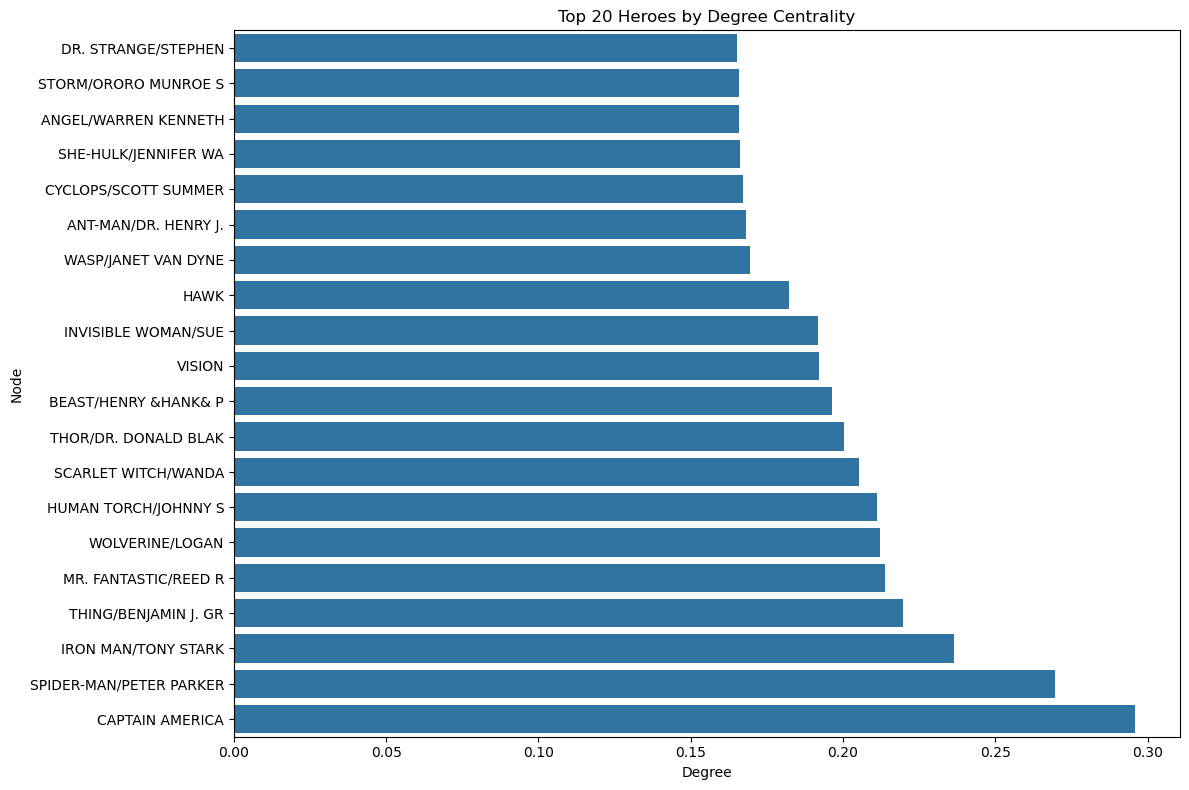

In [58]:
# Compute basic centrality measures for the hero network
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=100)  # Using k for approximation in large networks
    closeness_centrality = nx.closeness_centrality(G)

    # Create a dataframe with the centrality measures
    centrality_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Degree': [degree_centrality[node] for node in G.nodes()],
        'Betweenness': [betweenness_centrality[node] for node in G.nodes()],
        'Closeness': [closeness_centrality[node] for node in G.nodes()]
    })

    return centrality_df

# Compute centrality measures for the hero network
hero_centrality = compute_centrality_measures(G_hero)

# Sort by degree centrality to find the most central heroes
top_heroes = hero_centrality.sort_values('Degree', ascending=False).head(20)
print("\nTop 20 heroes by degree centrality:")
display(top_heroes)

# Visualize top heroes by degree centrality
plt.figure(figsize=(12, 8))
sns.barplot(x='Degree', y='Node', data=top_heroes.sort_values('Degree'))
plt.title('Top 20 Heroes by Degree Centrality')
plt.tight_layout()
plt.show()

### 4.1.3 Network Density

In [28]:
# Network density calculation
density = nx.density(G_hero)
print(f"Network density: {density:.6f}")


Network density: 0.008062


This is a very sparse network - heroes are connected to very few other heroes relative to the possible connections.

### 4.1.4 Community detection

Hero network: 6437 nodes and 167007 edges
Number of connected components: 23
Largest component size: 6400 heroes
Using giant component with 6400 nodes for community detection

1. Running Louvain community detection...
Louvain detected 19 communities
Top 10 Louvain communities by size:
1. Community size: 1324 heroes
2. Community size: 1078 heroes
3. Community size: 1050 heroes
4. Community size: 909 heroes
5. Community size: 828 heroes
6. Community size: 371 heroes
7. Community size: 276 heroes
8. Community size: 167 heroes
9. Community size: 119 heroes
10. Community size: 117 heroes
Louvain modularity score: 0.4179


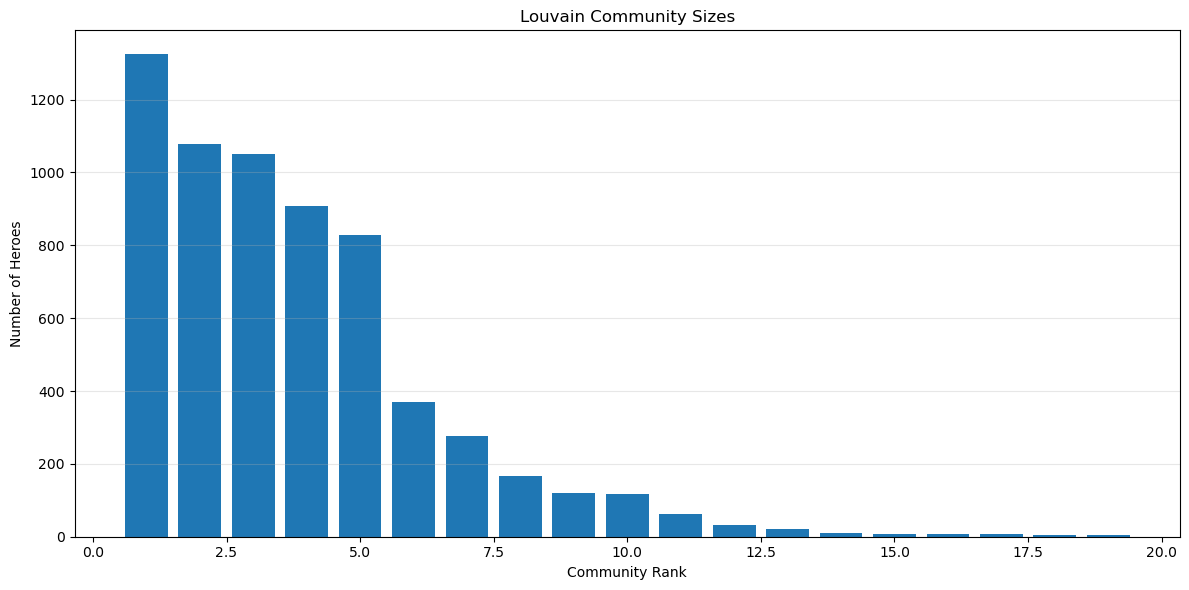


2. Running Label Propagation community detection...
Label Propagation detected 77 communities
Top 10 Label Propagation communities by size:
1. Community size: 5653 heroes
2. Community size: 117 heroes
3. Community size: 45 heroes
4. Community size: 34 heroes
5. Community size: 31 heroes
6. Community size: 30 heroes
7. Community size: 30 heroes
8. Community size: 25 heroes
9. Community size: 24 heroes
10. Community size: 23 heroes


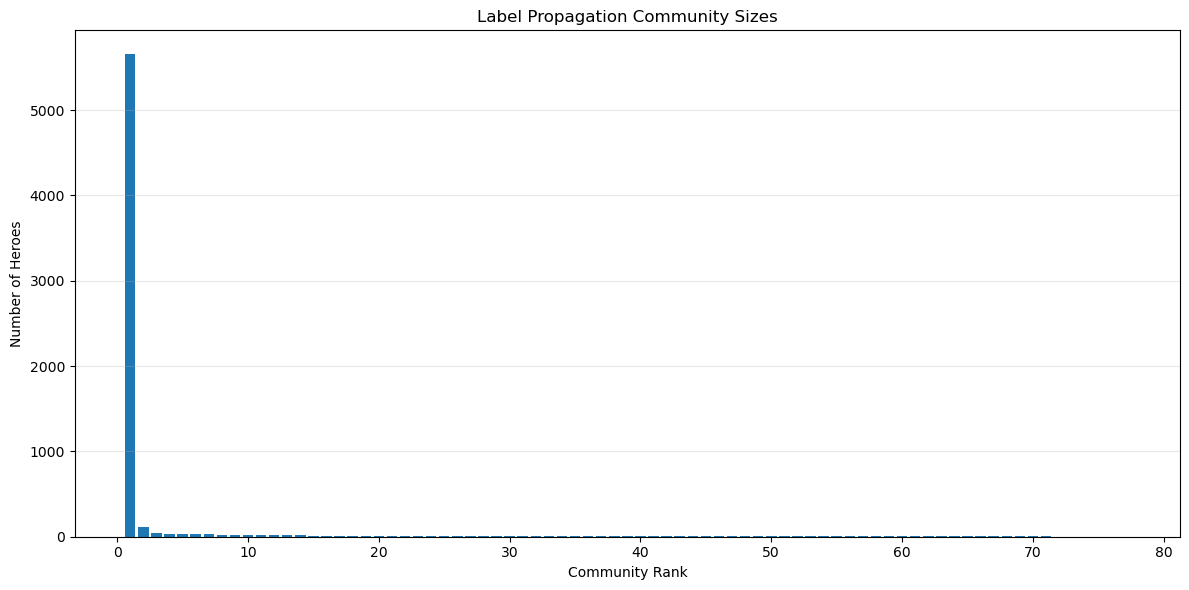

In [70]:
print(f"Hero network: {G_hero.number_of_nodes()} nodes and {G_hero.number_of_edges()} edges")

# First, find connected components
components = list(nx.connected_components(G_hero))
components.sort(key=len, reverse=True)
print(f"Number of connected components: {len(components)}")
print(f"Largest component size: {len(components[0])} heroes")

# We'll focus on the giant component for community detection
if len(components[0]) < G_hero.number_of_nodes():
    giant_component = G_hero.subgraph(components[0])
    print(f"Using giant component with {giant_component.number_of_nodes()} nodes for community detection")
else:
    giant_component = G_hero
    print("The graph is fully connected. Using the entire graph for community detection.")

# Method 1: Louvain Community Detection using NetworkX implementation
try:
    print("\n1. Running Louvain community detection...")
    
    # Use NetworkX's Louvain implementation
    louvain_communities = nx.community.louvain_communities(giant_component)
    louvain_communities = list(louvain_communities)  # Convert to list of sets
    
    print(f"Louvain detected {len(louvain_communities)} communities")
    
    # Sort communities by size
    louvain_communities.sort(key=len, reverse=True)
    
    print("Top 10 Louvain communities by size:")
    for i, community in enumerate(louvain_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} heroes")
    
    # Create a partition dictionary for visualization and further analysis
    louvain_partition = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            louvain_partition[node] = i
    
    # Calculate modularity
    modularity = nx.community.modularity(giant_component, louvain_communities)
    print(f"Louvain modularity score: {modularity:.4f}")
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in louvain_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Heroes')
    plt.title('Louvain Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Louvain community detection: {e}")
    print("This might be due to an older version of NetworkX. Try updating or use another method.")

# Method 2: Label Propagation
try:
    print("\n2. Running Label Propagation community detection...")
    lpa_communities = nx.algorithms.community.label_propagation_communities(giant_component)
    lpa_communities = list(lpa_communities)
    print(f"Label Propagation detected {len(lpa_communities)} communities")
    
    # Sort communities by size
    lpa_communities.sort(key=len, reverse=True)
    
    print("Top 10 Label Propagation communities by size:")
    for i, community in enumerate(lpa_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} heroes")
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in lpa_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Heroes')
    plt.title('Label Propagation Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Label Propagation: {e}")


### 4.1.5. Average Path Length

In [31]:
# Get the connected components
components = list(nx.connected_components(G_hero))
num_components = len(components)
print(f"Number of connected components: {num_components}")

# Get the sizes of the components
component_sizes = [len(c) for c in components]
largest_component_size = max(component_sizes)
print(f"Size of largest connected component: {largest_component_size}")
print(f"Percentage of heroes in largest component: {largest_component_size / G_hero.number_of_nodes() * 100:.2f}%")

if num_components > 1:
    print(f"Sizes of next 5 largest components: {sorted(component_sizes, reverse=True)[1:6]}")

# Extract the largest connected component for path length analysis
largest_cc = G_hero.subgraph(components[component_sizes.index(largest_component_size)])
print(f"\nAnalyzing largest connected component with {largest_cc.number_of_nodes()} nodes and {largest_cc.number_of_edges()} edges")

# Calculate the average shortest path length for the largest component
avg_path_length = nx.average_shortest_path_length(largest_cc)
print(f"Average shortest path length: {avg_path_length:.4f}")

# Calculate the diameter (longest shortest path)
# diameter = nx.diameter(largest_cc)
# print(f"Network diameter (longest shortest path): {diameter}")

# Calculate the radius
# radius = nx.radius(largest_cc)
# print(f"Network radius: {radius}")

print("- Random networks with same size and density would have path lengths of approximately ln(n)/ln(k)")
print(f"  where n={largest_cc.number_of_nodes()} and k=average degree ~{2*largest_cc.number_of_edges()/largest_cc.number_of_nodes():.2f}")

Number of connected components: 23
Size of largest connected component: 6400
Percentage of heroes in largest component: 99.43%
Sizes of next 5 largest components: [9, 7, 2, 1, 1]

Analyzing largest connected component with 6400 nodes and 166951 edges


KeyboardInterrupt: 

This is a very compact network with an average of only 2.64 steps between any two heroes. This suggests a 'small world' property - any hero can reach any other through just a few connections.

### 4.1.6 Degree Distribution

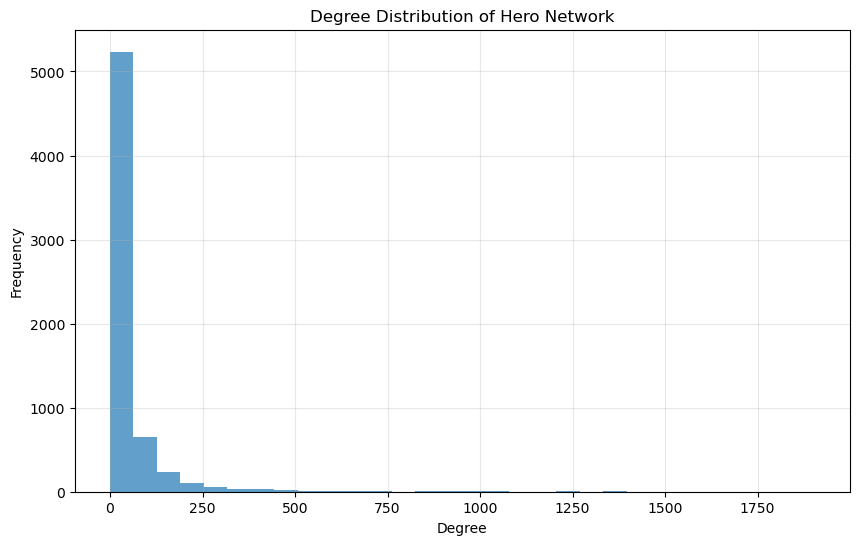

In [33]:

# Plot degree distribution
degrees = [d for n, d in G_hero.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Hero Network')
plt.grid(True, alpha=0.3)
plt.show()

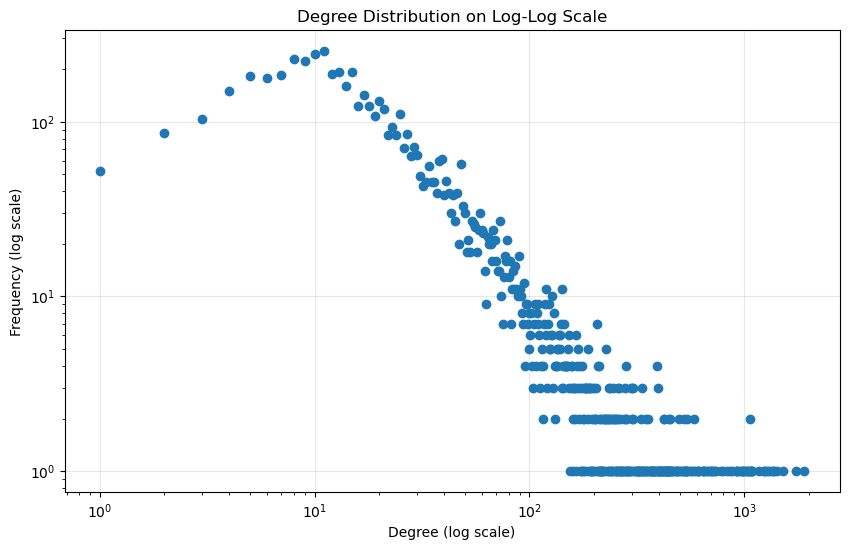

In [34]:
# Plot degree distribution on log-log scale to check for power law
degree_counts = pd.Series(degrees).value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.loglog(degree_counts.index, degree_counts.values, 'o')
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution on Log-Log Scale')
plt.grid(True, alpha=0.3)
plt.show()

## 4.2. Hero-comic bipartite network 

Since the hero-comic network is not a usual network, we will do different analysis than the ones we did for the hero-hero network: 
- 4.2.1 Basic Descriptive analysis
- 4.2.2 Degree Distribution
- 4.2.3 Bipartite Projections (hero to comic and comic to hero)
    - 4.2.3.1 Clustering coefficient
    - 4.2.3.2 Centrality Measures
    - 4.2.3.3 Communities
- 4.2.4 Component Analysis
- 4.2.5 Bipartite clustering coefficient
- 4.2.6 Assortativity

In [35]:
# Create a NetworkX graph for the bipartite hero-comic network
G_bipartite = nx.Graph()

# Add all nodes
for _, row in nodes_df.iterrows():
    G_bipartite.add_node(row['node'], type=row['type'])

# Add edges from the hero-comic connections
for _, row in edges_df.iterrows():
    G_bipartite.add_edge(row['hero'], row['comic'])

In [ ]:
# First, check if all nodes have the 'type' attribute
nodes_with_type = sum(1 for _, attr in G_bipartite.nodes(data=True) if 'type' in attr)
print(f"Nodes with 'type' attribute: {nodes_with_type}/{G_bipartite.number_of_nodes()}")

if nodes_with_type < G_bipartite.number_of_nodes():
    print("WARNING: Some nodes don't have 'type' attribute. Fixing this issue...")
    
    # Option 1: Try to infer node types based on the bipartite structure
    # This assumes heroes only connect to comics and vice versa
    
    # First identify all heroes and comics from nodes_df
    known_heroes = set(row['node'] for _, row in nodes_df.iterrows() 
                      if row['type'] == 'hero')
    known_comics = set(row['node'] for _, row in nodes_df.iterrows() 
                      if row['type'] == 'comic')
    
    # Get all nodes from the graph
    all_nodes = set(G_bipartite.nodes())
    
    # Find nodes without type attributes
    untyped_nodes = all_nodes - known_heroes - known_comics
    print(f"Found {len(untyped_nodes)} nodes without type information")
    
    # For nodes in edges_df but not in nodes_df, try to infer their type
    for node in untyped_nodes:
        # Check if it connects to any known hero
        connects_to_hero = any(neighbor in known_heroes 
                              for neighbor in G_bipartite.neighbors(node))
        # Check if it connects to any known comic
        connects_to_comic = any(neighbor in known_comics 
                               for neighbor in G_bipartite.neighbors(node))
        
        if connects_to_hero and not connects_to_comic:
            # If it only connects to heroes, it must be a comic
            G_bipartite.nodes[node]['type'] = 'comic'
        elif connects_to_comic and not connects_to_hero:
            # If it only connects to comics, it must be a hero
            G_bipartite.nodes[node]['type'] = 'hero'
        else:
            # If we can't infer, default to 'unknown'
            G_bipartite.nodes[node]['type'] = 'unknown'
    
    # Check again
    nodes_with_type = sum(1 for _, attr in G_bipartite.nodes(data=True) if 'type' in attr)
    print(f"After fixing: Nodes with 'type' attribute: {nodes_with_type}/{G_bipartite.number_of_nodes()}")


Nodes with 'type' attribute: 19088/19091
Found 3 nodes without type information
After fixing: Nodes with 'type' attribute: 19091/19091


### 4.2.1 Basic descriptive statistics

In [39]:
print("\nBipartite Hero-Comic Network Stats:")
print(f"Number of nodes: {G_bipartite.number_of_nodes()}")
print(f"Number of edges: {G_bipartite.number_of_edges()}")
print(f"Network density: {nx.density(G_bipartite):.6f}")


Bipartite Hero-Comic Network Stats:
Number of nodes: 19091
Number of edges: 96104
Network density: 0.000527


### 4.2.2 Degree Distribution

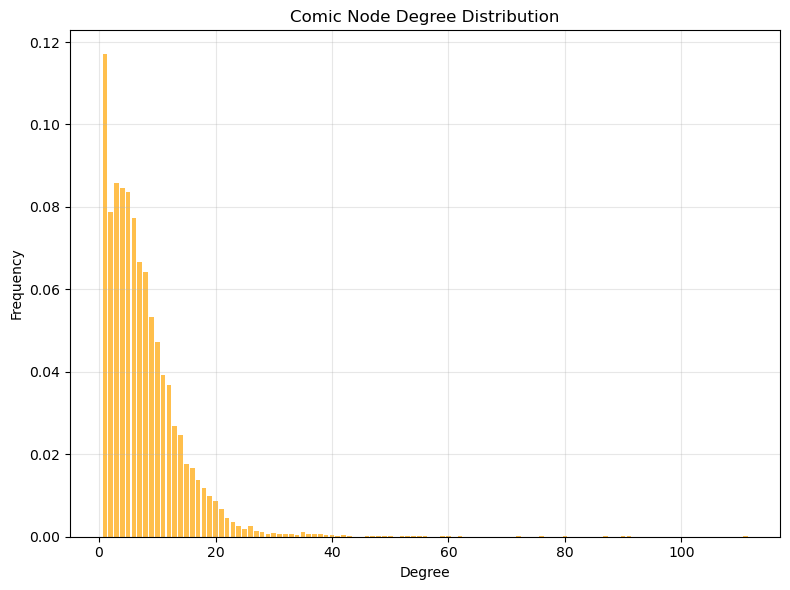

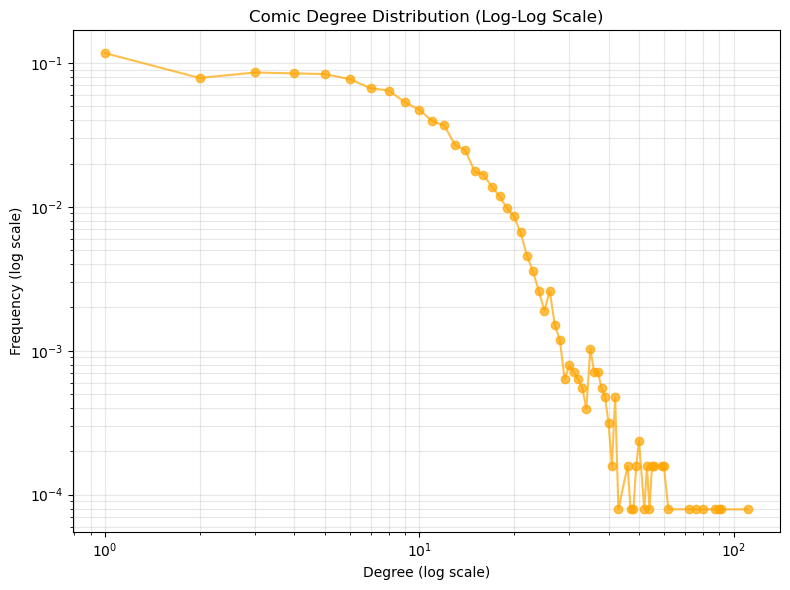


Comic degree statistics:
  min_degree: 1
  max_degree: 111
  mean_degree: 7.596553632123943
  median_degree: 6.0


In [59]:
# Get degrees for different node types
comic_nodes = [node for node, attr in G_bipartite.nodes(data=True) if attr['type'] == 'comic']

# Calculate degrees
comic_degrees = [G_bipartite.degree(node) for node in comic_nodes]

# Create degree distributions
comic_degree_dist = Counter(comic_degrees)

# Convert to DataFrames for easier plotting
comic_df = pd.DataFrame({
    'Degree': list(comic_degree_dist.keys()),
    'Count': list(comic_degree_dist.values())
})
comic_df['Frequency'] = comic_df['Count'] / comic_df['Count'].sum()
comic_df = comic_df.sort_values('Degree')

# Create a figure with two subplots
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

# Plot comic degree distribution
ax2.bar(comic_df['Degree'], comic_df['Frequency'], alpha=0.7, color='orange')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Frequency')
ax2.set_title('Comic Node Degree Distribution')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check for power law distribution (log-log plot)
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

# Comic log-log plot
comic_df_nonzero = comic_df[comic_df['Count'] > 0]  # Avoid log(0)
ax2.loglog(comic_df_nonzero['Degree'], comic_df_nonzero['Frequency'], 'o-', alpha=0.7, color='orange')
ax2.set_xlabel('Degree (log scale)')
ax2.set_ylabel('Frequency (log scale)')
ax2.set_title('Comic Degree Distribution (Log-Log Scale)')
ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

comic_stats = {
    'min_degree': min(comic_degrees),
    'max_degree': max(comic_degrees),
    'mean_degree': np.mean(comic_degrees),
    'median_degree': np.median(comic_degrees)
}

print("\nComic degree statistics:")
for stat, value in comic_stats.items():
    print(f"  {stat}: {value}")

**Fit power law to degree distribution**

In [60]:
def fit_power_law(degrees, node_type):
    # Use only degrees > 0 for log fitting
    degrees_for_fit = [d for d in degrees if d > 0]
    if len(degrees_for_fit) > 1:
        log_degrees = np.log(degrees_for_fit)
        log_freqs = np.log([hero_degree_dist[d] / len(hero_degrees) 
                           if node_type == 'hero' else 
                           comic_degree_dist[d] / len(comic_degrees) 
                           for d in degrees_for_fit])
        
        # Linear regression on log-log data
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_freqs)
        
        print(f"\n{node_type.capitalize()} power law fit:")
        print(f"  Exponent (slope): {slope:.4f}")
        print(f"  R-squared: {r_value**2:.4f}")
        print(f"  p-value: {p_value:.4e}")
        
        return slope, intercept, r_value**2
    else:
        print(f"\nNot enough data points to fit power law for {node_type}s")
        return None, None, None

# Fit power laws
comic_power_law = fit_power_law(list(comic_degree_dist.keys()), 'comic')



Comic power law fit:
  Exponent (slope): -2.4184
  R-squared: 0.8563
  p-value: 2.2134e-27


### 4.2.3 Bipartite Projection of Comics

Now we create one projection of the bipartite graph: the comic projection where comics are connected if they share heroes. We don't create a hero projection, because this corresponds to the hero-hero network.

In [61]:
# Identify the node sets (heroes and comics)
comic_nodes = [node for node, attr in G_bipartite.nodes(data=True) 
              if attr.get('type', '') == 'comic']

print(f"Number of comics: {len(comic_nodes)}")

# Create comic projection (comics connected if they share heroes)
print("\nCreating comic projection graph (comic-comic)...")
G_comic_projection = nx.algorithms.bipartite.projected_graph(G_bipartite, comic_nodes)
print(f"Comic projection has {G_comic_projection.number_of_nodes()} nodes and {G_comic_projection.number_of_edges()} edges")


Number of comics: 12651

Creating comic projection graph (comic-comic)...
Comic projection has 12651 nodes and 7022085 edges


#### 4.2.3.1 Clustering coefficient

In [55]:
if G_comic_projection.number_of_edges() > 0:
    comic_clustering = nx.average_clustering(G_comic_projection)
    print(f"Comic projection average clustering coefficient: {comic_clustering:.4f}")
else:
    print("Comic projection has no edges, cannot calculate clustering")

KeyboardInterrupt: 

#### 4.2.3.2 Basic properties analysis


--- Comic Projection Analysis ---
Average degree: 1110.12
Min degree: 0
Max degree: 9665
Number of connected components: 22
Largest component size: 12626 comics
Percentage of comics in giant component: 99.80%


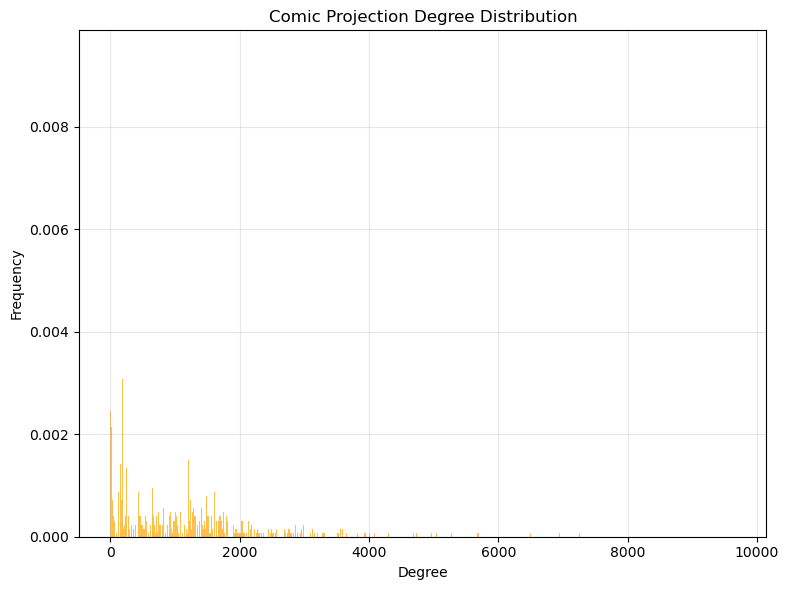

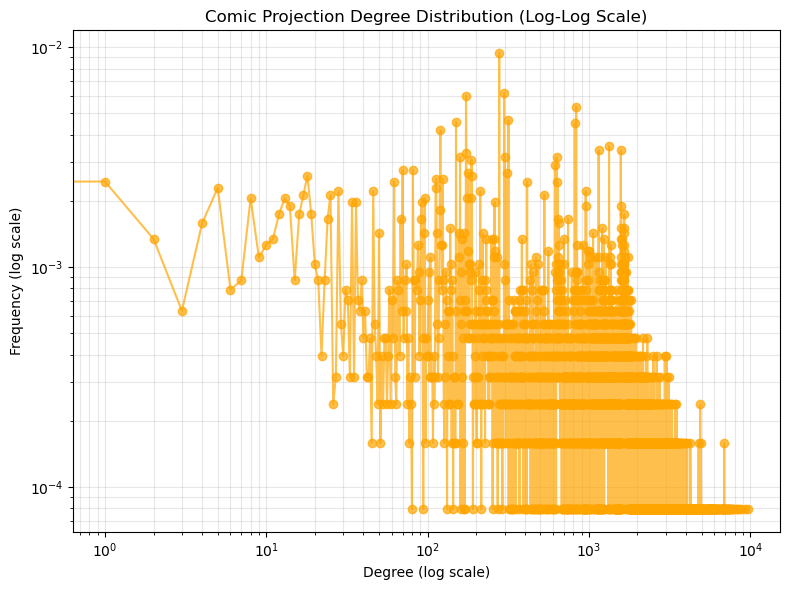

In [63]:
# Analyze basic properties of the projections
print("\n--- Comic Projection Analysis ---")
comic_degrees = [G_comic_projection.degree(node) for node in G_comic_projection.nodes()]
if comic_degrees:
    print(f"Average degree: {np.mean(comic_degrees):.2f}")
    print(f"Min degree: {min(comic_degrees)}")
    print(f"Max degree: {max(comic_degrees)}")
    
    # Analyze connected components
    comic_components = list(nx.connected_components(G_comic_projection))
    print(f"Number of connected components: {len(comic_components)}")
    comic_components.sort(key=len, reverse=True)
    if comic_components:
        print(f"Largest component size: {len(comic_components[0])} comics")
        giant_comic_pct = (len(comic_components[0]) / G_comic_projection.number_of_nodes()) * 100
        print(f"Percentage of comics in giant component: {giant_comic_pct:.2f}%")

# Visualize degree distributions
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

if comic_degrees:
    comic_degree_count = Counter(comic_degrees)
    comic_degree_dist = pd.DataFrame({
        'Degree': list(comic_degree_count.keys()),
        'Count': list(comic_degree_count.values())
    })
    comic_degree_dist['Frequency'] = comic_degree_dist['Count'] / sum(comic_degree_dist['Count'])
    comic_degree_dist = comic_degree_dist.sort_values('Degree')
    
    ax2.bar(comic_degree_dist['Degree'], comic_degree_dist['Frequency'], alpha=0.7, color='orange')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Comic Projection Degree Distribution')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Create log-log plots to check for power-law distributions
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

# Comic projection log-log plot
if comic_degrees and len(comic_degree_dist) > 0:
    comic_degree_dist_nonzero = comic_degree_dist[comic_degree_dist['Count'] > 0]
    if not comic_degree_dist_nonzero.empty:
        ax2.loglog(comic_degree_dist_nonzero['Degree'], comic_degree_dist_nonzero['Frequency'], 'o-', alpha=0.7, color='orange')
        ax2.set_xlabel('Degree (log scale)')
        ax2.set_ylabel('Frequency (log scale)')
        ax2.set_title('Comic Projection Degree Distribution (Log-Log Scale)')
        ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


#### 4.2.3.3 Communities

Comic projection graph: 12651 nodes and 7022085 edges
Number of connected components: 22
Largest component size: 12626 comics
Using giant component with 12626 nodes for community detection

1. Running Louvain community detection...
Louvain detected 11 communities
Top 10 Louvain communities by size:
1. Community size: 3377 heroes
2. Community size: 2429 heroes
3. Community size: 1770 heroes
4. Community size: 1725 heroes
5. Community size: 1576 heroes
6. Community size: 1393 heroes
7. Community size: 303 heroes
8. Community size: 19 heroes
9. Community size: 14 heroes
10. Community size: 10 heroes
Louvain modularity score: 0.4624


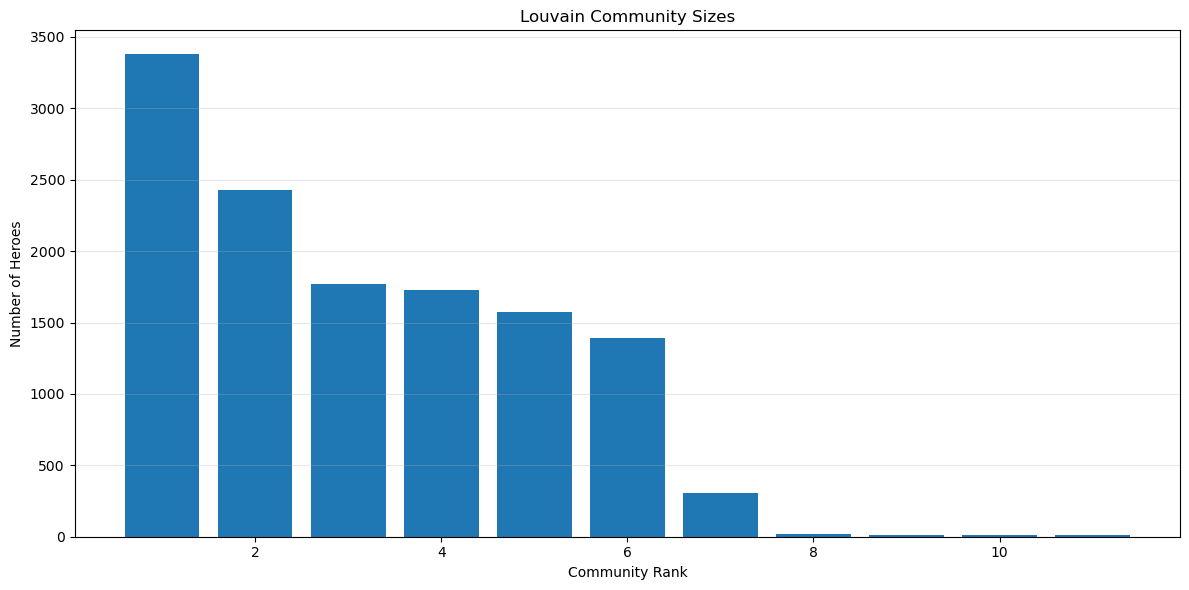


2. Running Label Propagation community detection...
Label Propagation detected 18 communities
Top 10 Label Propagation communities by size:
1. Community size: 12310 comics
2. Community size: 142 comics
3. Community size: 27 comics
4. Community size: 22 comics
5. Community size: 19 comics
6. Community size: 14 comics
7. Community size: 14 comics
8. Community size: 13 comics
9. Community size: 11 comics
10. Community size: 10 comics


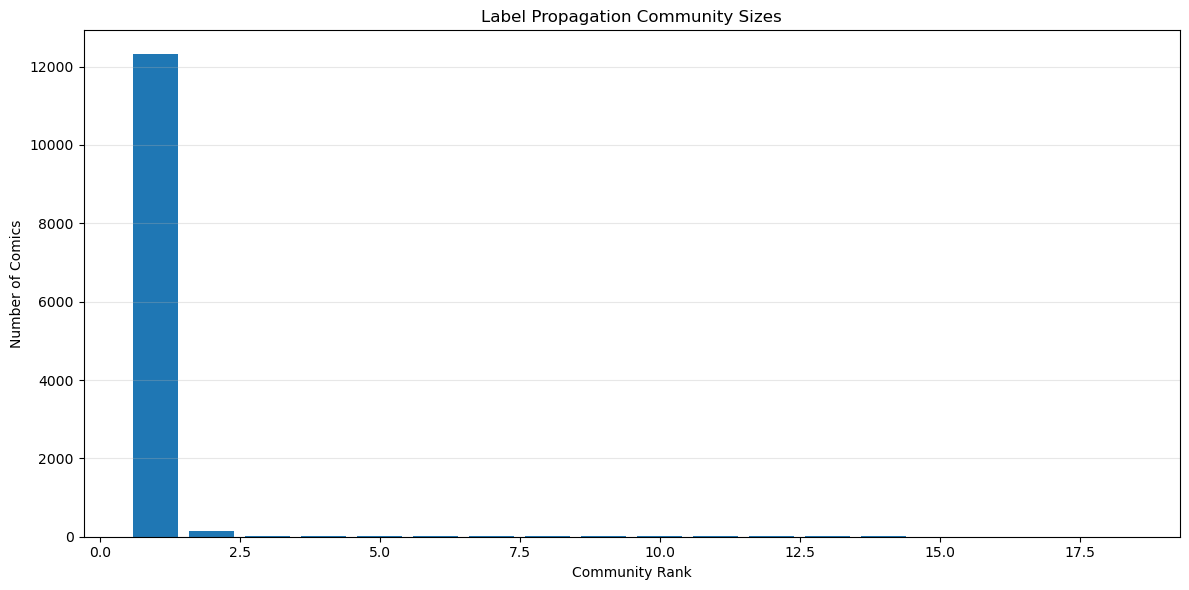

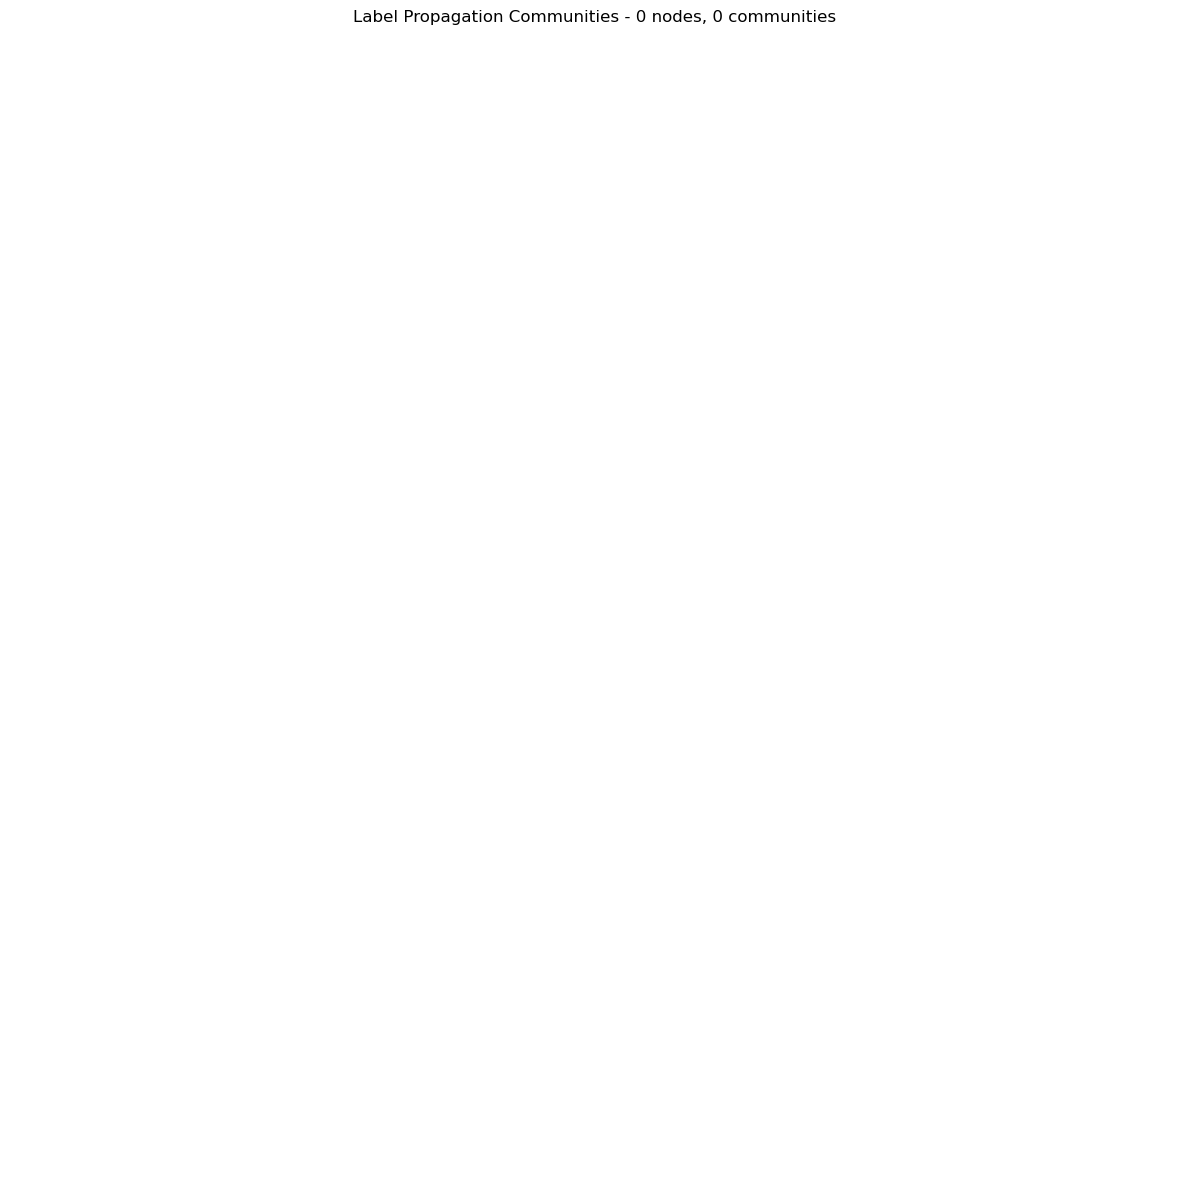


Analyzing hero composition of comic communities...
Error in hero composition analysis: 'list' object has no attribute 'items'


In [ ]:
print(f"Comic projection graph: {G_comic_projection.number_of_nodes()} nodes and {G_comic_projection.number_of_edges()} edges")

# First, find connected components
components = list(nx.connected_components(G_comic_projection))
components.sort(key=len, reverse=True)
print(f"Number of connected components: {len(components)}")
print(f"Largest component size: {len(components[0])} comics")

# We'll focus on the giant component for community detection
if len(components[0]) < G_comic_projection.number_of_nodes():
    giant_component = G_comic_projection.subgraph(components[0])
    print(f"Using giant component with {giant_component.number_of_nodes()} nodes for community detection")
else:
    giant_component = G_comic_projection
    print("The graph is fully connected. Using the entire graph for community detection.")

# Method 1: Louvain Community Detection using NetworkX implementation
try:
    print("\n1. Running Louvain community detection...")
    
    # Use NetworkX's Louvain implementation
    louvain_communities = nx.community.louvain_communities(giant_component)
    louvain_communities = list(louvain_communities)  # Convert to list of sets
    
    print(f"Louvain detected {len(louvain_communities)} communities")
    
    # Sort communities by size
    louvain_communities.sort(key=len, reverse=True)
    
    print("Top 10 Louvain communities by size:")
    for i, community in enumerate(louvain_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} heroes")
    
    # Create a partition dictionary for visualization and further analysis
    louvain_partition = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            louvain_partition[node] = i
    
    # Calculate modularity
    modularity = nx.community.modularity(giant_component, louvain_communities)
    print(f"Louvain modularity score: {modularity:.4f}")
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in louvain_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Heroes')
    plt.title('Louvain Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Louvain community detection: {e}")
    print("This might be due to an older version of NetworkX. Try updating or use another method.")

# Method 2: Label Propagation
try:
    print("\n2. Running Label Propagation community detection...")
    lpa_communities = nx.algorithms.community.label_propagation_communities(giant_component)
    lpa_communities = list(lpa_communities)
    print(f"Label Propagation detected {len(lpa_communities)} communities")
    
    # Sort communities by size
    lpa_communities.sort(key=len, reverse=True)
    
    print("Top 10 Label Propagation communities by size:")
    for i, community in enumerate(lpa_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} comics")
    
    # Create a partition dict for visualization
    lpa_partition = {}
    for i, community in enumerate(lpa_communities):
        for node in community:
            lpa_partition[node] = i
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in lpa_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Comics')
    plt.title('Label Propagation Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Label Propagation: {e}")


# Community Analysis - Hero Composition
# This analyzes which heroes appear in which comic communities
try:
    print("\nAnalyzing hero composition of comic communities...")
    
    # Use Louvain communities if available, otherwise use Label Propagation
    if 'louvain_communities' in locals():
        selected_communities = louvain_communities
        community_method = "Louvain"
    elif 'lpa_communities' in locals():
        selected_communities = {i: list(comm) for i, comm in enumerate(lpa_communities)}
        community_method = "Label Propagation"
    else:
        print("No community detection results available for hero composition analysis")
        raise Exception("Missing community detection results")
    
    # Analyze top communities
    top_communities = sorted([(comm_id, len(nodes)) for comm_id, nodes in selected_communities.items()], 
                            key=lambda x: x[1], reverse=True)[:5]  # Top 5 communities
    
    print(f"Analyzing hero composition for top {len(top_communities)} {community_method} communities...")
    
    for rank, (comm_id, size) in enumerate(top_communities, 1):
        comics = selected_communities[comm_id]
        
        # Find heroes that appear in these comics
        community_heroes = defaultdict(int)
        
        for comic in comics:
            # Get heroes connected to this comic in the original bipartite graph
            for hero in G_bipartite.neighbors(comic):
                if G_bipartite.nodes[hero].get('type', '') == 'hero':
                    community_heroes[hero] += 1
        
        # Sort heroes by frequency
        top_heroes = sorted(community_heroes.items(), key=lambda x: x[1], reverse=True)[:20]
        
        print(f"\nCommunity {rank} ({size} comics)")
        print("Top heroes in this community:")
        for i, (hero, count) in enumerate(top_heroes, 1):
            print(f"{i}. {hero}: appears in {count} comics ({count/size:.1%} of community)")
    
except Exception as e:
    print(f"Error in hero composition analysis: {e}")

### 4.2.4 Component Analysis

In [46]:
# Get connected components
components = list(nx.connected_components(G_bipartite))
print(f"Number of connected components: {len(components)}")

# Sort components by size (largest first)
components.sort(key=len, reverse=True)

# Analyze component sizes
component_sizes = [len(c) for c in components]
print(f"Largest component size: {component_sizes[0]} nodes")
print(f"Second largest component size: {component_sizes[1] if len(component_sizes) > 1 else 'N/A'} nodes")

# Calculate what percentage of nodes are in the largest component (giant component)
giant_component_percentage = (component_sizes[0] / G_bipartite.number_of_nodes()) * 100
print(f"Percentage of nodes in giant component: {giant_component_percentage:.2f}%")

# Analyze node types in the largest component
largest_component = components[0]
giant = G_bipartite.subgraph(largest_component)

# Count node types in giant component
giant_heroes = [node for node, attr in giant.nodes(data=True) 
                if attr.get('type', '') == 'hero']
giant_comics = [node for node, attr in giant.nodes(data=True) 
                if attr.get('type', '') == 'comic']

print(f"Heroes in giant component: {len(giant_heroes)}")
print(f"Comics in giant component: {len(giant_comics)}")


Number of connected components: 23
Largest component size: 19029 nodes
Second largest component size: 11 nodes
Percentage of nodes in giant component: 99.68%
Heroes in giant component: 6403
Comics in giant component: 12626



Hero-Comic Ratios in Top Components:
   component   size  heroes  comics  hero_ratio
0          1  19029    6403   12626    0.336486
1          2     11       9       2    0.818182
2          3      8       7       1    0.875000
3          4      4       2       2    0.500000
4          5      3       1       2    0.333333
5          6      3       1       2    0.333333
6          7      2       1       1    0.500000
7          8      2       1       1    0.500000
8          9      2       1       1    0.500000
9         10      2       1       1    0.500000


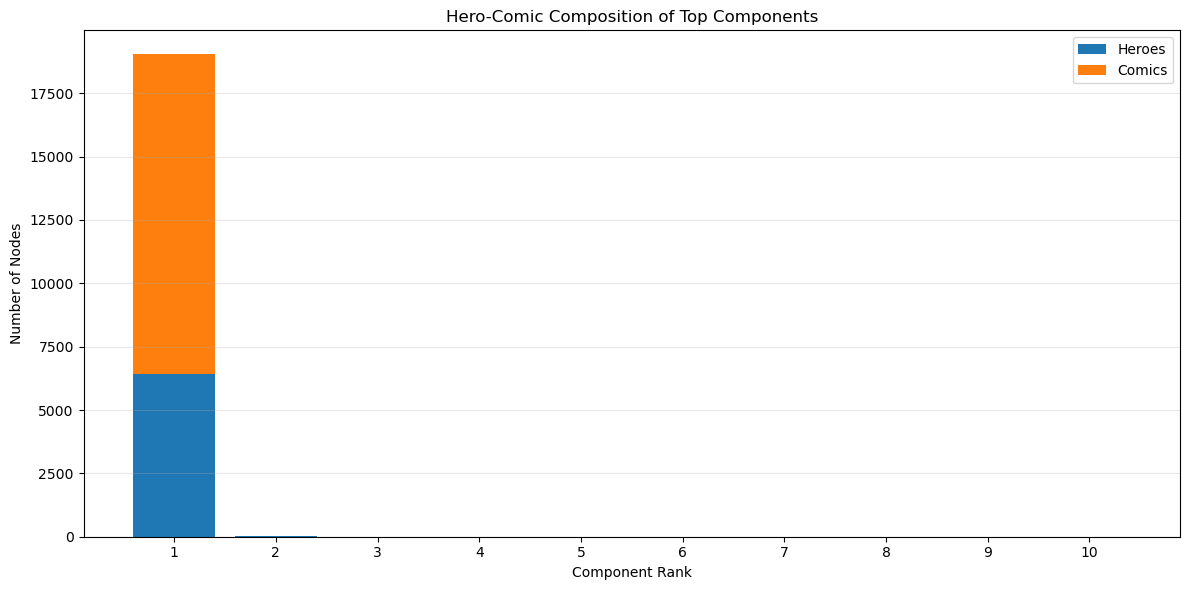

In [49]:
# Optional: Analyze hero-comic ratio across components
component_ratios = []
for i, comp in enumerate(components[:min(10, len(components))]):  # Analyze top 10 components
    subgraph = G_bipartite.subgraph(comp)
    heroes = len([node for node, attr in subgraph.nodes(data=True) if attr.get('type', '') == 'hero'])
    comics = len([node for node, attr in subgraph.nodes(data=True) if attr.get('type', '') == 'comic'])
    total = heroes + comics
    if total > 0:  # Avoid division by zero
        hero_ratio = heroes / total
        component_ratios.append({
            'component': i + 1,
            'size': total,
            'heroes': heroes,
            'comics': comics,
            'hero_ratio': hero_ratio
        })

# Display hero-comic ratio for top components
ratio_df = pd.DataFrame(component_ratios)
print("\nHero-Comic Ratios in Top Components:")
print(ratio_df)

# Visualize hero-comic composition of top components
if not ratio_df.empty:
    plt.figure(figsize=(12, 6))
    plt.bar(ratio_df['component'], ratio_df['heroes'], label='Heroes')
    plt.bar(ratio_df['component'], ratio_df['comics'], bottom=ratio_df['heroes'], label='Comics')
    plt.xlabel('Component Rank')
    plt.ylabel('Number of Nodes')
    plt.title('Hero-Comic Composition of Top Components')
    plt.legend()
    plt.xticks(ratio_df['component'])
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# 5. Network visualisation

## 5.1 Hero-hero network